In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [22]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
data = np.array(data)
m,n = data.shape
print(m,n)

42000 785


In [24]:
np.random.shuffle(data)
data_dev = data[0:1000].T
y_dev = data_dev[0] #selecting the first row which contains labels of each training samples
x_dev = data_dev[1:n] /255.0
data_train = data[1000:m].T
y_train = data_train[0]
x_train = data_train[1:n] /255.0
print(y_train)

[0 7 2 ... 2 9 9]


In [25]:
print(x_train[:, 0].shape)

(784,)


In [27]:
def init_parameters():
    W1 = np.random.randn(64, 784) * 0.01 
    b1 = np.zeros((64, 1))
    W2 = np.random.randn(64, 64) * 0.01
    b2 = np.zeros((64, 1))
    W3 = np.random.randn(10, 64) * 0.01
    b3 = np.zeros((10, 1))
    
    return {
        "W1" : W1, 
        "W2" : W2,
        "W3" : W3, 
        "b1" : b1, 
        "b2" : b2, 
        "b3" : b3
    }

def ReLu(z):
    return np.maximum(0,z)

def SoftMax(z):
    z_shifted = z - np.max(z, axis = 0, keepdims = True)
    z_exp = np.exp(z_shifted) #shifted to prevent overflow 
    exponential_sum = np.sum (z_exp, axis = 0, keepdims = True)
    return z_exp / exponential_sum # returns an array of probablistic distributions
    

def forward_propagation(X, parameters):
    Z1 = parameters["W1"].dot(X) + parameters["b1"]
    a1 = ReLu(Z1) 
    Z2 = parameters["W2"].dot(a1) + parameters["b2"]
    a2 = ReLu(Z2) 
    Z3 = parameters["W3"].dot(a2) + parameters["b3"]
    a3 = SoftMax(Z3) 
    
    return Z1, a1, Z2, a2, Z3, a3

def one_hot_encoding(Y):
    Y_encoded = np.zeros((Y.size, 10))
    Y_encoded[np.arange(Y.size), Y] = 1
    return Y_encoded.T

def calculate_loss(a3, y):
    #using cross entropy loss fn here 
    epsilon = 1e-12
    #predicted probablities are clipped between 0 and 1 to avoid crashes ( log(0) =1 , log(1) = 0)
    a3_clipped = np.clip(a3, epsilon, 1-epsilon)
    loss = -np.sum(y * np.log(a3_clipped))/y.shape[1]
    return loss

    
def backward_propagation(X, Y_hot_encoded, parameters, Z1, a1, Z2, a2, Z3, a3, m):
    dZ3 = a3 - Y_hot_encoded
    dZ2 = parameters["W3"].T.dot(dZ3) * (Z2 > 0)
    dZ1 = parameters["W2"].T.dot(dZ2) * (Z1 > 0)

    dW3 = dZ3.dot(a2.T) / m
    dW2 = dZ2.dot(a1.T) / m
    dW1 = dZ1.dot(X.T) / m

    db3 = np.sum(dZ3, axis = 1 , keepdims = True) / m
    db2 = np.sum(dZ2, axis = 1 , keepdims = True) / m
    db1 = np.sum(dZ1, axis = 1 , keepdims = True) / m

    return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3": db3}

def gradient_descent(gradients, parameters, lr):
        parameters["W3"] -= lr * gradients["dW3"]
        parameters["b3"] -= lr * gradients["db3"]
        parameters["W2"] -= lr * gradients["dW2"]
        parameters["b2"] -= lr * gradients["db2"]
        parameters["W1"] -= lr * gradients["dW1"]
        parameters["b1"] -= lr * gradients["db1"]
        return parameters

def train(X_train, Y_train, X_val, Y_val, learning_rate=0.001, epochs=1000, batch_size=128):
    parameters = init_parameters()
    losses = []
    val_accuracies = []
    for epoch in range(epochs):
        permutation = np.random.permutation(X_train.shape[1])
        X_shuffled = X_train[:, permutation]
        Y_shuffled = Y_train[permutation]
        epoch_loss = 0
        num_batches = 0
        for i in range(0, X_train.shape[1], batch_size):
            X_batch = X_shuffled[:, i:i+batch_size]
            Y_batch = Y_shuffled[i:i+batch_size]
            Z1, A1, Z2, A2, Z3, A3 = forward_propagation(X_batch, parameters)
            Y_one_hot = one_hot_encoding(Y_batch)
            loss = calculate_loss(A3, Y_one_hot)
            gradients = backward_propagation(X_batch, Y_one_hot, parameters, Z1, A1, Z2, A2, Z3, A3, batch_size)
            parameters = gradient_descent(gradients, parameters, learning_rate)
            epoch_loss += loss
            num_batches += 1
            
        _, _, _, _, _, A3_val = forward_propagation(X_val, parameters)
        val_pred = np.argmax(A3_val, axis=0)
        val_acc = np.mean(val_pred == Y_val)
        val_accuracies.append(val_acc)
        
        avg_loss = epoch_loss / num_batches  # Average loss for the epoch
        losses.append(avg_loss) 
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {avg_loss}, Validation Accuracy: {val_acc * 100:.2f}%")
    return parameters, losses, val_accuracies

trained_params, losses, val_accuracies = train(x_train, y_train, x_dev, y_dev, learning_rate=0.1, epochs=1000, batch_size=64)


Epoch 0, Loss: 1.8491187642434164, Validation Accuracy: 79.90%
Epoch 100, Loss: 0.0002604937873250084, Validation Accuracy: 97.90%
Epoch 200, Loss: 9.803807051295966e-05, Validation Accuracy: 97.70%
Epoch 300, Loss: 5.769962615510562e-05, Validation Accuracy: 97.70%
Epoch 400, Loss: 3.9989716140364416e-05, Validation Accuracy: 97.70%
Epoch 500, Loss: 3.0238237992556754e-05, Validation Accuracy: 97.70%
Epoch 600, Loss: 2.4122697441045282e-05, Validation Accuracy: 97.70%
Epoch 700, Loss: 1.996685037071086e-05, Validation Accuracy: 97.70%
Epoch 800, Loss: 1.6952082316703878e-05, Validation Accuracy: 97.70%
Epoch 900, Loss: 1.4690376247372549e-05, Validation Accuracy: 97.70%


In [28]:
def compute_accuracy(X, Y, parameters):
    _, _, _, _, _, A3 = forward_propagation(X, parameters)
    predictions = np.argmax(A3, axis=0)
    return np.mean(predictions == Y)

val_accuracy = compute_accuracy(x_dev, y_dev, trained_params)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


Validation Accuracy: 97.70%


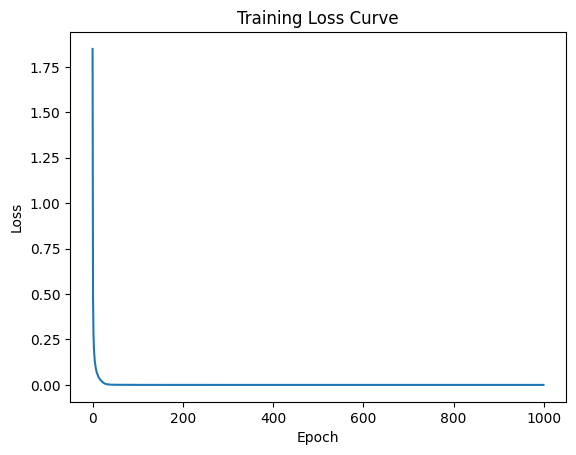

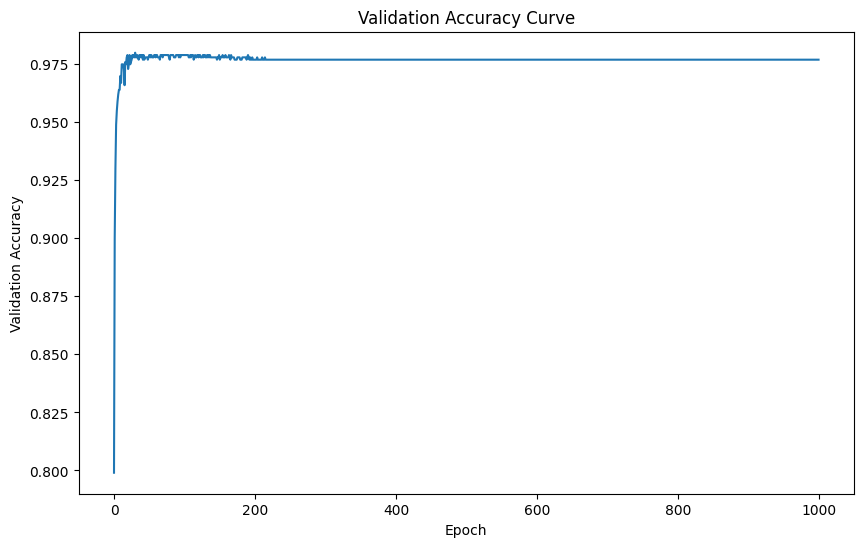

In [29]:
#loss curve
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

#validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Curve')
plt.show()

In [30]:
# Calculate final predictions on validation set
_, _, _, _, _, A3_val = forward_propagation(x_dev, trained_params)
val_pred = np.argmax(A3_val, axis=0)

Confusion Matrix:
[[ 96   0   1   0   0   0   0   0   1   0]
 [  0 126   1   0   0   0   0   2   0   0]
 [  0   0  99   1   0   0   0   0   3   0]
 [  0   0   0  86   0   0   0   0   1   0]
 [  0   0   0   0  93   0   1   0   0   1]
 [  2   0   0   0   0  86   0   0   0   0]
 [  1   0   0   0   0   0  89   0   0   0]
 [  0   0   0   0   0   0   0 107   0   0]
 [  0   0   0   1   0   1   1   1  98   0]
 [  0   0   0   0   2   1   1   0   0  97]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        98
           1       1.00      0.98      0.99       129
           2       0.98      0.96      0.97       103
           3       0.98      0.99      0.98        87
           4       0.98      0.98      0.98        95
           5       0.98      0.98      0.98        88
           6       0.97      0.99      0.98        90
           7       0.97      1.00      0.99       107
           8       0.95      0.96      0.

<Figure size 1000x800 with 0 Axes>

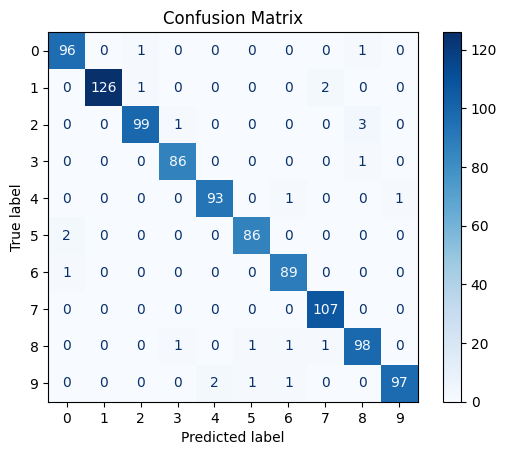

In [31]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

#confusion matrix
cm = confusion_matrix(y_dev, val_pred)
print("Confusion Matrix:")
print(cm)

#classification report
report = classification_report(y_dev, val_pred)
print("Classification Report:")
print(report)

#confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


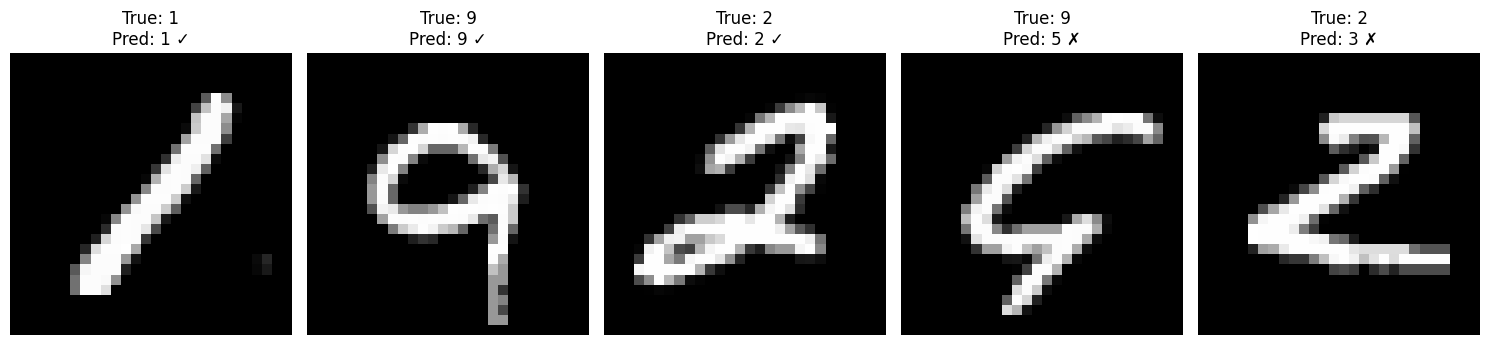

In [32]:
# Visualize sample predictions (including both correct and incorrect)
import random

# Find indices of correct and incorrect predictions
correct_indices = np.where(val_pred == y_dev)[0]
incorrect_indices = np.where(val_pred != y_dev)[0]

# Select 3 correct and 2 incorrect predictions randomly (if available)
num_correct = min(3, len(correct_indices))
num_incorrect = min(2, len(incorrect_indices))

sample_correct = random.sample(list(correct_indices), num_correct)
sample_incorrect = random.sample(list(incorrect_indices), num_incorrect) if len(incorrect_indices) > 0 else []
sample_indices = sample_correct + sample_incorrect

# Plot the samples
plt.figure(figsize=(15, 10))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, len(sample_indices), i+1)
    image = x_dev[:, idx].reshape(28, 28)
    plt.imshow(image, cmap='gray')
    prediction_status = "✓" if val_pred[idx] == y_dev[idx] else "✗"
    plt.title(f"True: {y_dev[idx]}\nPred: {val_pred[idx]} {prediction_status}")
    plt.axis('off')
plt.tight_layout()
plt.show()
